In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import cleanup

In [2]:
#cleanup.clean_up()

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, class_names, transform=None):
        self.data_dir = data_dir
        self.class_names = class_names
        self.transform = transform
        self.file_list = []  # List of file names
        self.labels = [] # List of labels (0/1)

        # 获取数据文件夹中的文件列表和标签
        for label in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label)
            if os.path.isdir(label_dir):
                files = os.listdir(label_dir)
                self.file_list.extend(files)
                for i, name in enumerate(class_names):
                    if label == name:
                        self.labels.extend([i] * len(files))
                        break


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, self.class_names[self.labels[idx]], file_name)
        data = np.load(file_path)['matrix1']
        label = self.labels[idx]

        if self.transform:
            data = self.transform(data)
        if data.shape != torch.Size([1, 224, 224]):
            print(file_path)
        
        return data, label


def normalize_array(arr, lb, ub):
    arr = np.clip(arr, lb, ub)  # 将数值限制在0到0.01之间
    max_val, min_val = np.max(arr), np.min(arr)
    if max_val == min_val:
        return np.ones_like(arr)
    arr = (arr - min_val) / (max_val - min_val)  # 归一化到0到1之间
    return arr


def numpy_to_pil(sample):
    sample = normalize_array(sample, 0, 0.01)
    sample = np.squeeze(sample)  # 去除维度为1的维度
    sample = Image.fromarray(sample, mode='F')  # 指定图像模式为float32
    return sample


data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(numpy_to_pil),  # 添加自定义转换函数
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Lambda(numpy_to_pil),  # 添加自定义转换函数
        transforms.Resize(224),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Lambda(numpy_to_pil),  # 添加自定义转换函数
        transforms.Resize(224),
        transforms.ToTensor(),
    ]),
}

data_dir = '.\\preprocess'

class_names = ['negative', 'positive', 'test']

image_datasets = {x: CustomDataset(os.path.join(data_dir, x),
                                   class_names,
                                   data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, 
                             shuffle=True, num_workers=0)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

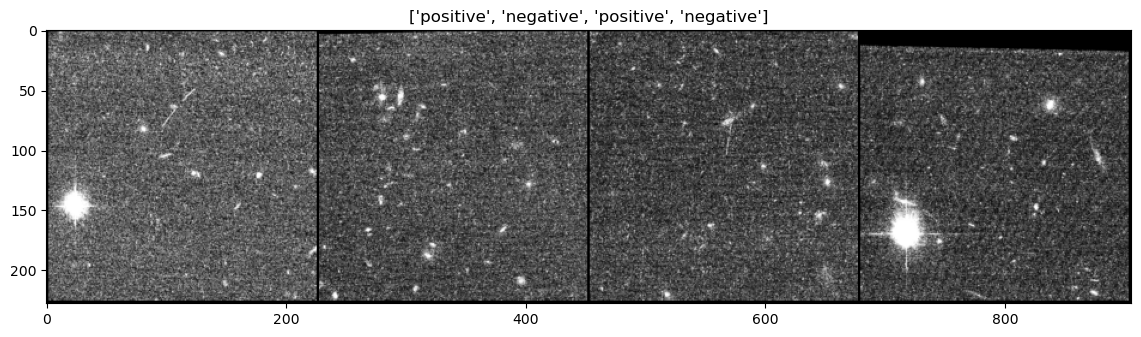

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    plt.figure(figsize=(14,8))
    inp = inp.numpy()
    inp = np.transpose(inp, (1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, cmap='gray', vmin=0, vmax=1)  # 指定灰度色彩映射
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=len(inputs))

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # For calculating precision, recall and F1 score
                all_preds = []
                all_labels = []

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    # Collect all predictions and labels
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Calculate and print precision, recall and F1 score
                precision = precision_score(all_labels, all_preds)
                recall = recall_score(all_labels, all_preds)
                f1 = f1_score(all_labels, all_preds)
                print(f'{phase} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}')
                
                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        # Test phase after all epochs
        phase = 'test'
        model.eval()
        
        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []
        
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        final_loss = running_loss / dataset_sizes[phase]
        final_acc = running_corrects.double() / dataset_sizes[phase]
        print(f'{phase} Loss: {final_loss:.4f} Acc: {final_acc:.4f}')
        
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        print(f'Test Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}')

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [9]:
model_ft = models.resnet34(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features
print(model_ft)
print('-----------------------')

conv1 = model_ft.conv1
w = conv1.weight
print(w.shape)
conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
conv1.weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
print(model_ft.conv1)
print(conv1)
print('-----------------------')
model_ft.conv1 = conv1

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)
print(model_ft)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8521 Acc: 0.5441
train Precision: 0.5584 Recall: 0.6056 F1: 0.5811
val Loss: 0.8670 Acc: 0.4857
val Precision: 0.4706 Recall: 1.0000 F1: 0.6400

Epoch 1/24
----------
train Loss: 0.8759 Acc: 0.5588
train Precision: 0.5714 Recall: 0.6197 F1: 0.5946
val Loss: 0.6854 Acc: 0.6286
val Precision: 0.6000 Recall: 0.5625 F1: 0.5806

Epoch 2/24
----------
train Loss: 0.6517 Acc: 0.6691
train Precision: 0.6857 Recall: 0.6761 F1: 0.6809
val Loss: 0.9007 Acc: 0.5714
val Precision: 0.5385 Recall: 0.4375 F1: 0.4828

Epoch 3/24
----------
train Loss: 0.6595 Acc: 0.7132
train Precision: 0.7353 Recall: 0.7042 F1: 0.7194
val Loss: 1.6813 Acc: 0.4571
val Precision: 0.4571 Recall: 1.0000 F1: 0.6275

Epoch 4/24
----------
train Loss: 0.4651 Acc: 0.8162
train Precision: 0.8026 Recall: 0.8592 F1: 0.8299
val Loss: 1.1548 Acc: 0.6286
val Precision: 0.6364 Recall: 0.4375 F1: 0.5185

Epoch 5/24
----------
train Loss: 0.6427 Acc: 0.7206
train Precision: 0.7200 Recall: 0.7606 F1:

KeyboardInterrupt: 

In [8]:
best_model_params_path = os.path.join('.\model', 'resnet18-1.pt')
torch.save(model_ft.state_dict(), best_model_params_path)

In [6]:
model_ft = models.vgg16(weights="IMAGENET1K_V1")
print(model_ft)
print('-----------------------')
num_ftrs = model_ft.classifier[3].in_features


conv1 = model_ft.features[0]
w = conv1.weight
print(w.shape)
conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
conv1.weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
print(model_ft.features[0])
print(conv1)
print('-----------------------')
model_ft.features[0] = conv1

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.classifier[6] = nn.Linear(num_ftrs, 2)
print(model_ft)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model